In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
figR = 3
figC = 3

# path = r'image/1_wIXlvBeAFtNVgJd49VObgQ_sinus.png'
# path = r'image/1_wIXlvBeAFtNVgJd49VObgQ.png'
path = r'image/1_wIXlvBeAFtNVgJd49VObgQ.png_Salt_Pepper_Noise1.png'
# path = r'image/1_zd6ypc20QAIFMzrbCmJRMg.png'
img = cv2.imread(path)
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Log_Img = 5 * np.log(1+grayImage)
img.shape

(461, 461, 3)

<Figure size 720x504 with 0 Axes>

# Test

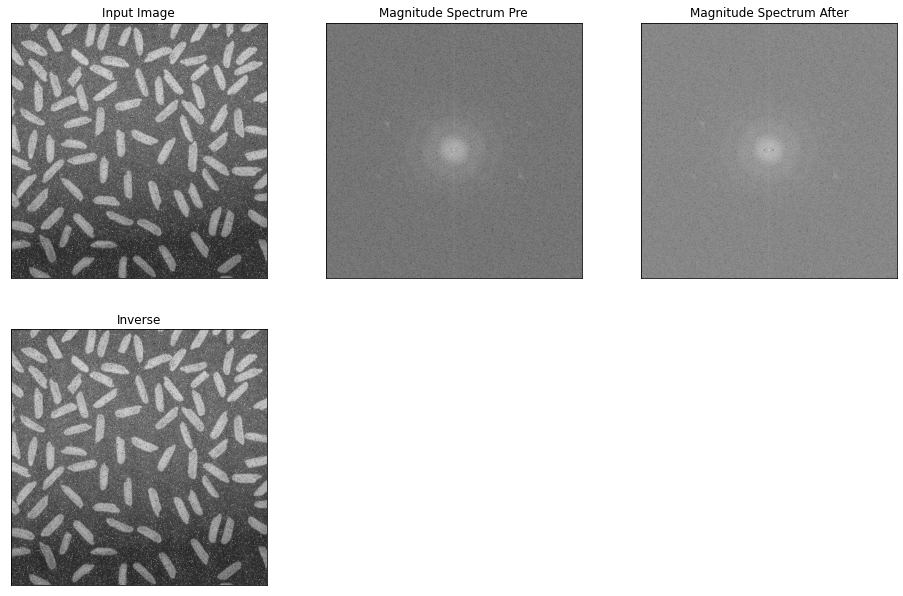

In [27]:
#nhiễu sin 
def sinusNoise(img, fig):
    try:
        #biến đổi Fourrier (zero padding)
        dft = np.fft.fft2(img)
        #chuyển frequency zero về  tâm giữa ảnh 
        dft_shift = np.fft.fftshift(dft)

        #độ lớn tần số 
        magnitude_spectrum_pre = 20 * np.log(np.abs(dft_shift))

        rows, cols = img.shape
        crow, ccol = int(rows/2), int(cols/2)

        mask = np.ones((rows, cols), np.uint8)

       
        #loại bỏ những thành phần chứa nhiễu sin 
        mask[crow, ccol-9: ccol-7] = 0
        mask[crow, ccol+7: ccol+9] = 0
        # mask[crow-30:crow+30, ccol-30:ccol+30] = 0 

        # mask = np.ndarray((rows,cols),)

        fshift = dft_shift*mask

        magnitude_spectrum_after = magnitude_spectrum_pre * mask

        f_ishift = np.fft.ifftshift(fshift)

        img_back = np.abs(np.fft.ifft2(f_ishift))
        img_back = img_back.astype(np.uint8)

        fig = plt.figure(figsize = (16,16))
        fig.add_subplot(figR, figC, 1), plt.imshow(img, cmap='gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        fig.add_subplot(figR, figC, 2), plt.imshow(
            magnitude_spectrum_pre, cmap='gray')
        plt.title('Magnitude Spectrum Pre'), plt.xticks([]), plt.yticks([])
        fig.add_subplot(figR, figC, 3), plt.imshow(
            magnitude_spectrum_after, cmap='gray')
        plt.title('Magnitude Spectrum After'), plt.xticks([]), plt.yticks([])
        fig.add_subplot(figR, figC, 4), plt.imshow(img_back, cmap='gray')
        plt.title('Inverse'), plt.xticks([]), plt.yticks([])
        img_back = img_back[0:460, 0:460]
        return img_back

    except Exception as e:
        print("Error", e)

filterSinus = sinusNoise(grayImage, fig)

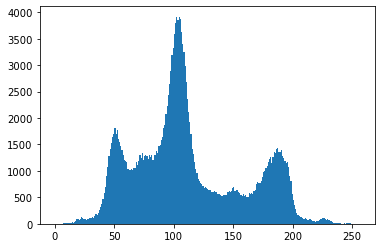

array([[ 2.],
       [ 2.],
       [ 4.],
       [ 1.],
       [ 5.],
       [ 2.],
       [ 2.],
       [12.],
       [ 6.],
       [ 6.]], dtype=float32)

In [28]:
hist1 = cv2.calcHist([filterSinus],[0],None,[256],[0,256])
plt.hist(filterSinus.ravel(),256,[0,256]); plt.show()
hist1[:10]

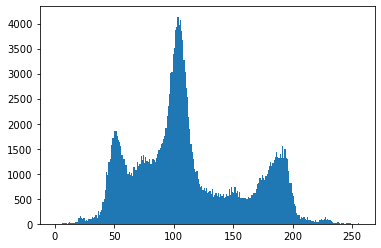

[[ 5.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 2.]
 [10.]
 [ 6.]
 [ 9.]
 [ 7.]]


In [29]:
plt.hist(grayImage.ravel(),256,[0,256]); plt.show()
hist2 = cv2.calcHist([grayImage],[0],None,[256],[0,256])
print(cv2.calcHist([grayImage],[0],None,[256],[0,256])[:10])

In [30]:
cdf = hist1.cumsum()
cdf_normalized = cdf * float(hist1.max()) / cdf.max()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
print(cv2.calcHist([cdf[filterSinus]],[0],None,[256],[0,256])[:10])

[[ 736.]
 [ 878.]
 [ 804.]
 [ 568.]
 [ 847.]
 [ 587.]
 [ 697.]
 [ 901.]
 [1065.]
 [   0.]]


In [31]:
equ = cv2.equalizeHist(filterSinus)

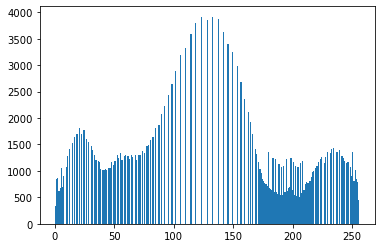

In [32]:
plt.hist(equ.ravel(),256,[0,256]); plt.show()

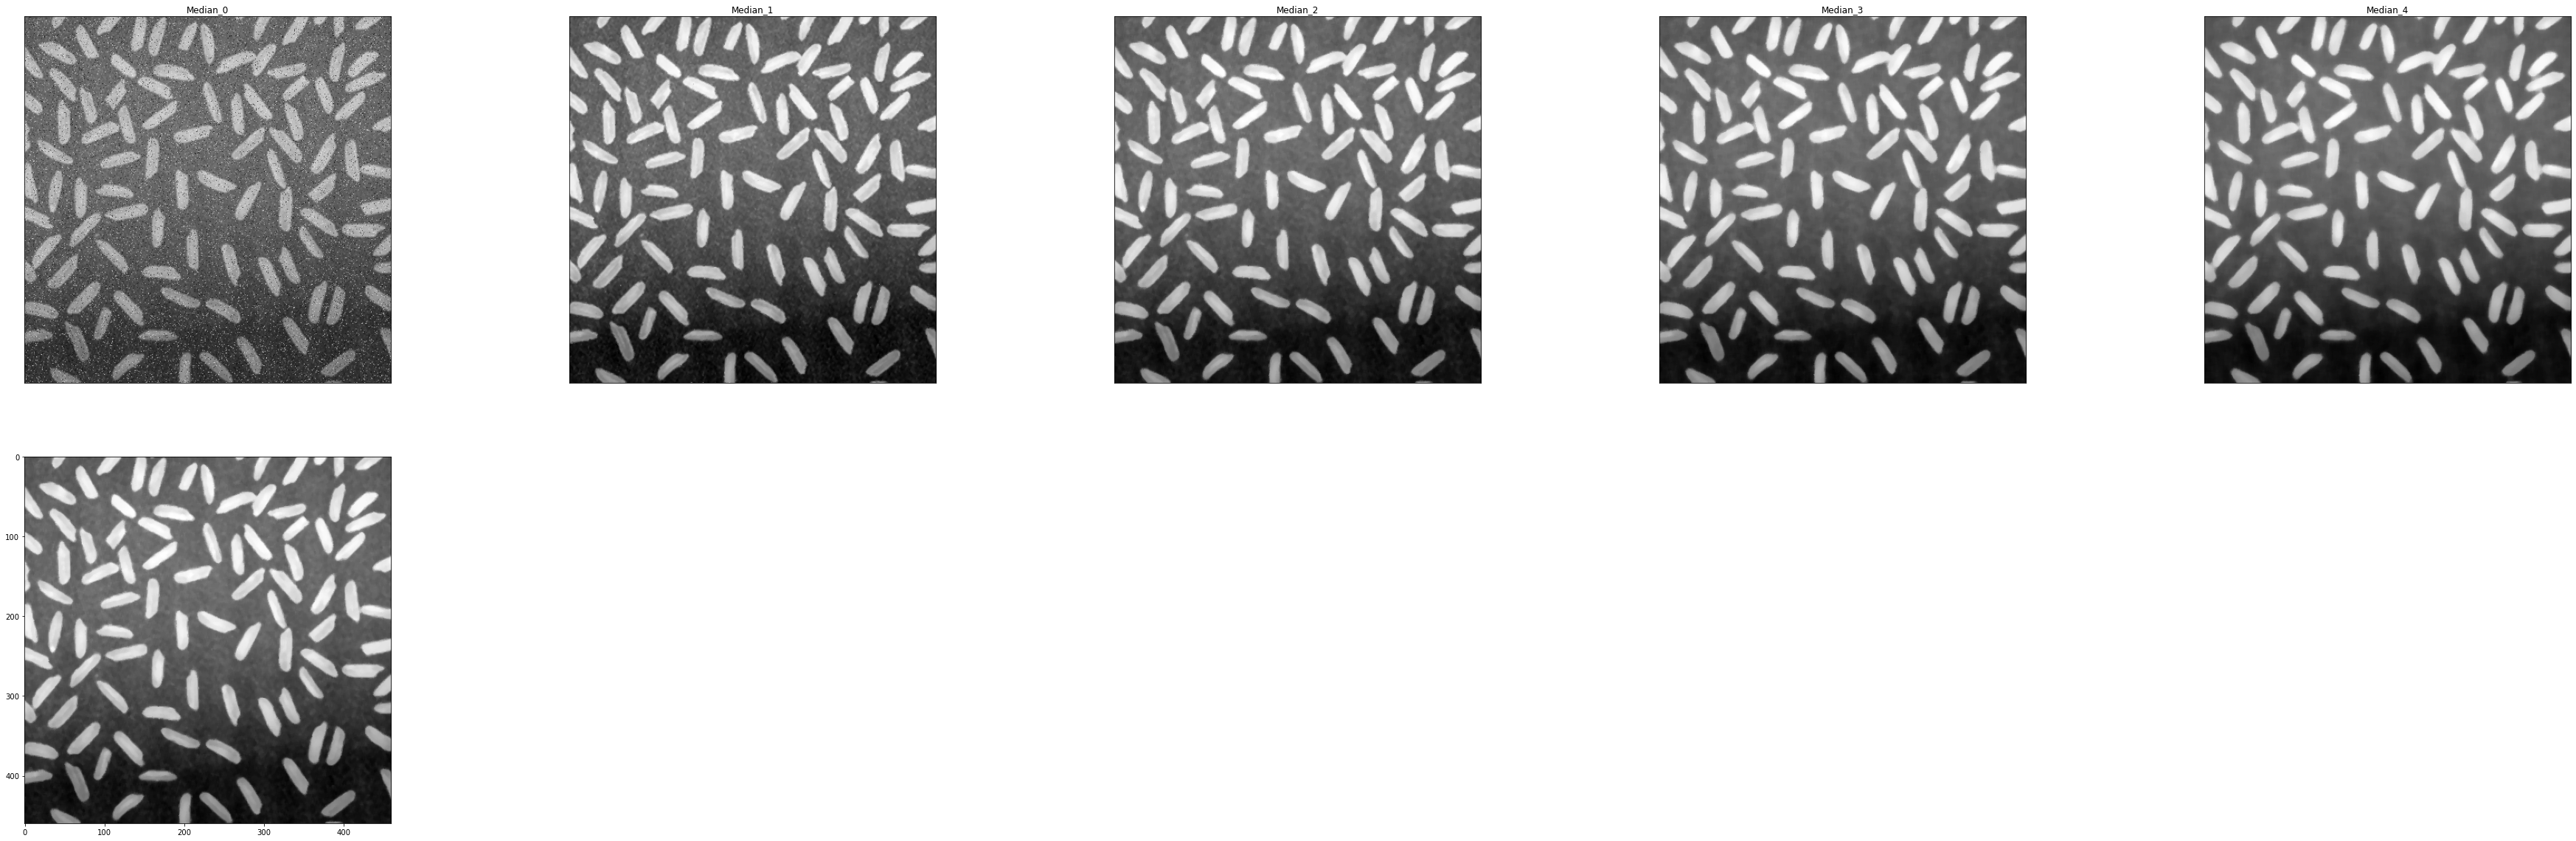

In [33]:
# Lọc nhiễu muối tiêu
sizes = [1,3,5,7,9]
fig = plt.figure(figsize = (64,64))
for i, size in enumerate(sizes):
    medianImage = cv2.medianBlur(filterSinus, size)
    plt.subplot(6,5,i+1)
    plt.imshow(medianImage, cmap='gray')
    plt.title('Median_{}'.format(i)), plt.xticks([]), plt.yticks([])

medianImage = cv2.medianBlur(filterSinus, 5)
plt.subplot(6,5,6)
plt.imshow(medianImage, cmap = 'gray')

(([], []), ([], []))

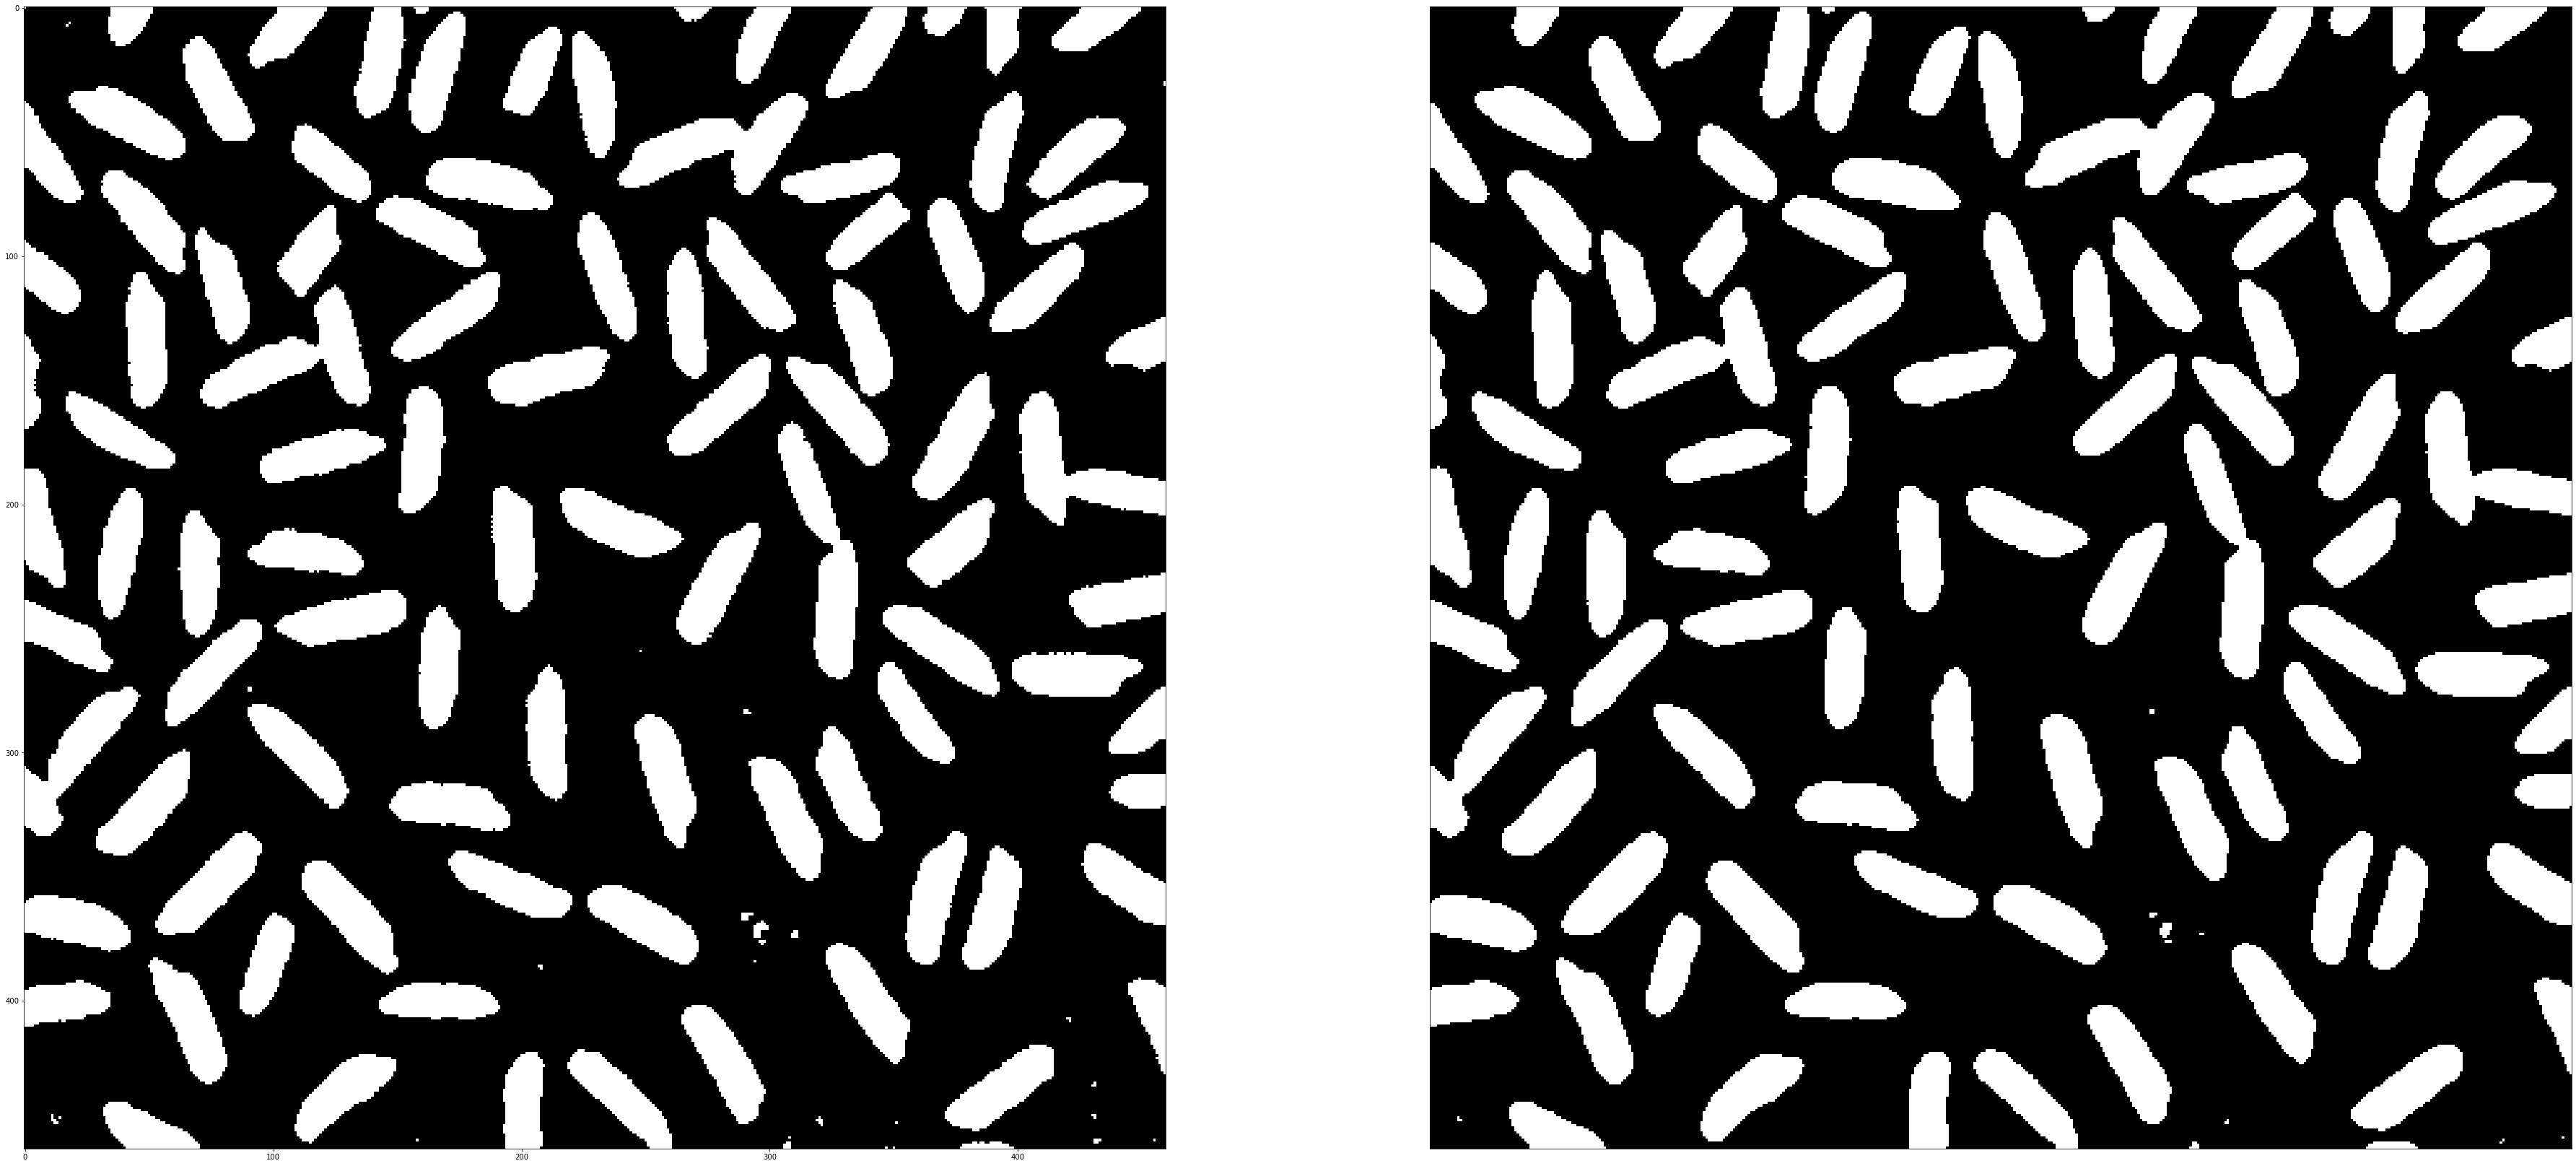

In [34]:
plt.figure(figsize = (64,64))
# cons = (2. * (medianImage/255.)**(0.10)* 255).astype('uint8')


blur = cv2.GaussianBlur(medianImage,(3,3),0)
ret2 = cv2.adaptiveThreshold(
         medianImage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, -1)
ret3 = cv2.adaptiveThreshold(
         blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, -1)         
plt.subplot(2,2,1)
plt.imshow(ret2, cmap = 'gray')
plt.subplot(2,2,2)
plt.imshow(ret3, cmap='gray')
plt.xticks([]), plt.yticks([])

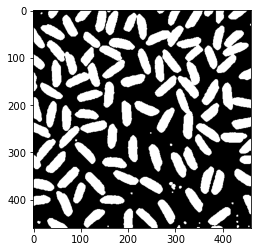

In [35]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
equ = clahe.apply(medianImage)
blur = cv2.GaussianBlur(ret2,(5,5),0)
thresh, im = cv2.threshold(blur, 10,  255, cv2.THRESH_BINARY)
plt.imshow(im, cmap = 'gray')

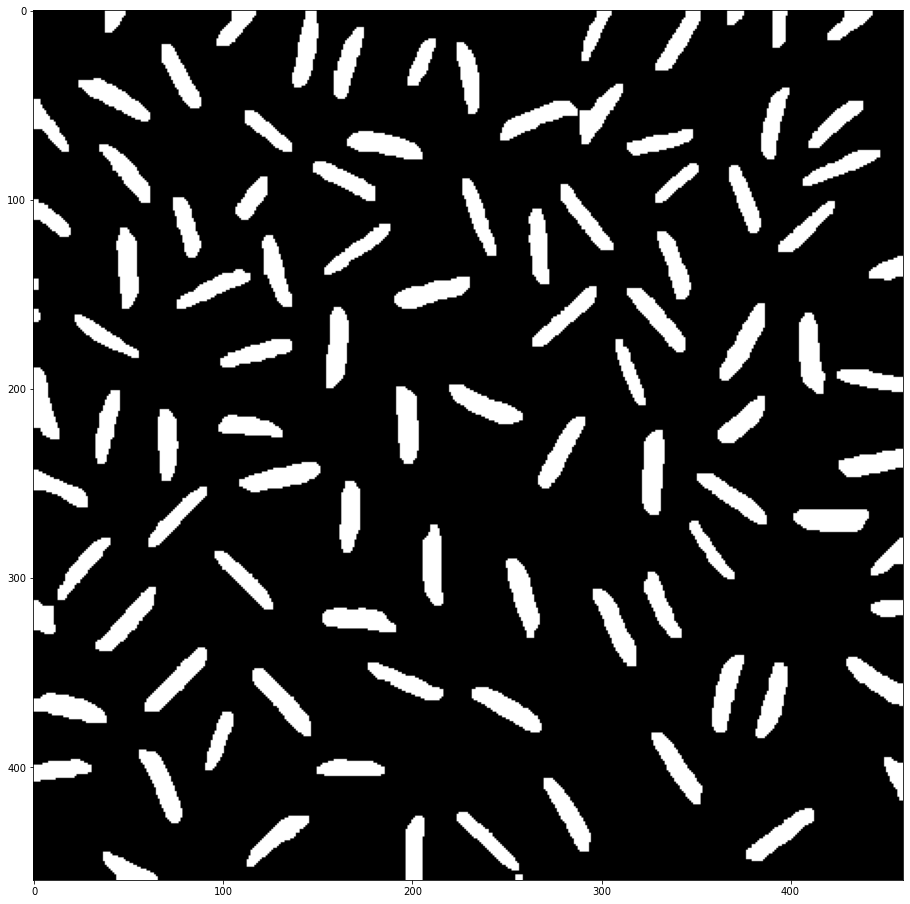

In [36]:
kernel = np.ones((9,9), np.uint8)
kernel2 = np.ones((4,4), np.uint8)
 
# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
plt.figure(figsize = (16,16))
img_erosion = cv2.erode(ret2, kernel, iterations=1)
img_dilate = cv2.dilate(img_erosion, kernel2, iterations = 1)
# img_med2 = cv2.medianBlur(ret2, 7)
plt.imshow(img_dilate, cmap = 'gray')

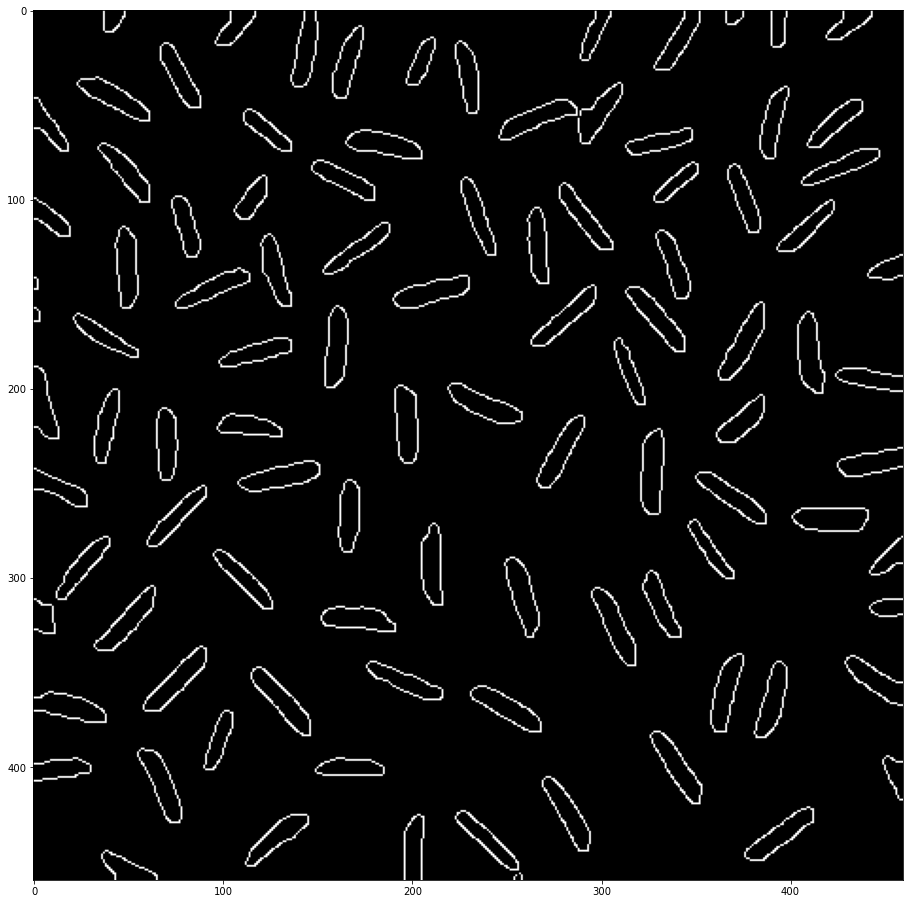

In [37]:
kernel = np.ones((6,6), np.uint8)
kernel2 = np.ones((4,4), np.uint8)
fig = plt.figure(figsize = (16,16))
edged = cv2.Canny(img_dilate, 10, 100)
# img_dilate2 = cv2.dilate(edged, kernel2, iterations = 2)
# img_erosion2 = cv2.erode(img_dilate2, kernel, iterations =1)
plt.imshow(edged, cmap = 'gray')

101


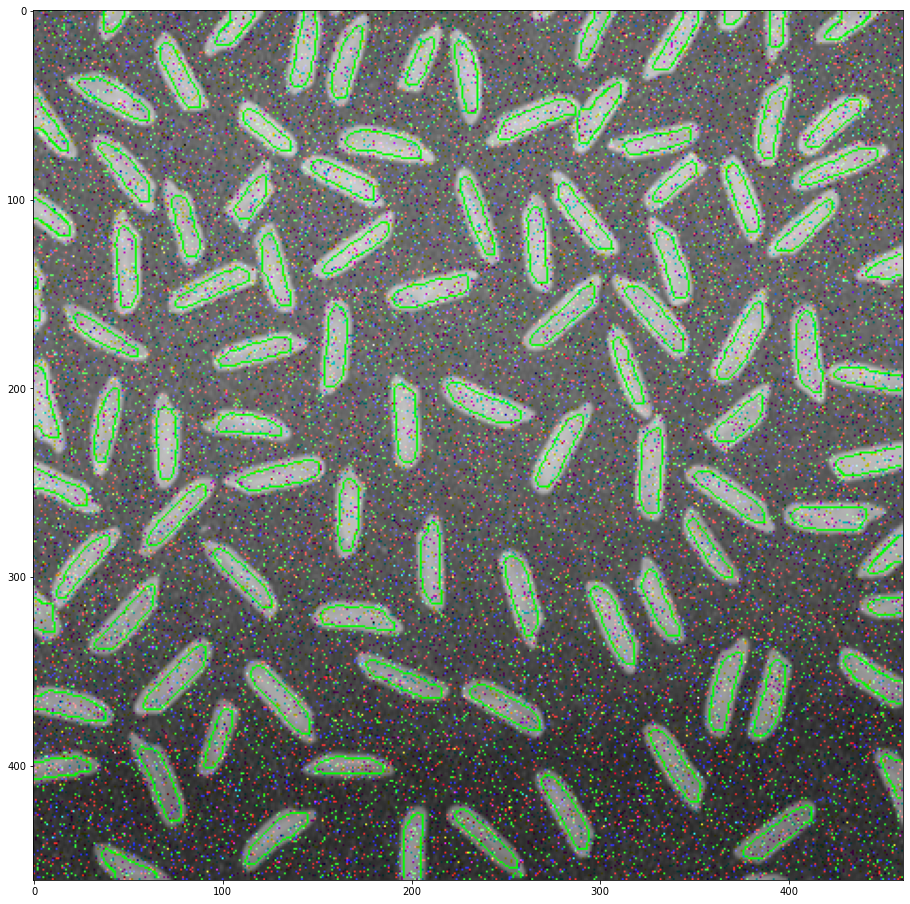

In [38]:

contours, hierarchy = cv2.findContours(
        edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rgb = img.copy()
plt.figure(figsize = (16,16))
cv2.drawContours(rgb, contours, -1, (0, 255, 0), 1)
plt.imshow(rgb)
print(len(contours))

# Final

(461, 461)
Number of object 96


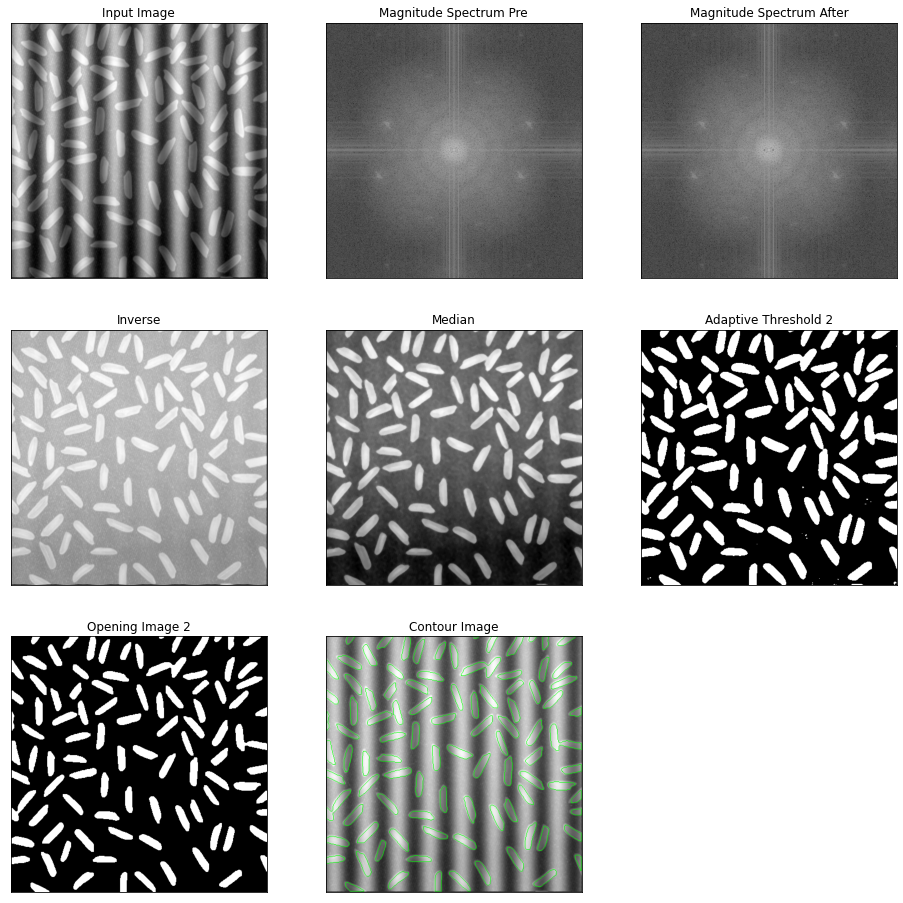

-1

In [39]:
fig = plt.figure(figsize=(16, 16))
figR = 3
figC = 3

path = r'image/1_wIXlvBeAFtNVgJd49VObgQ_sinus.png'
# path = r'image/1_wIXlvBeAFtNVgJd49VObgQ.png'
# path = r'image/1_wIXlvBeAFtNVgJd49VObgQ.png_Salt_Pepper_Noise1.png'
# path = r'image/1_zd6ypc20QAIFMzrbCmJRMg.png'
img = cv2.imread(path)

def sinusNoise(img):
    try:
        dft = np.fft.fft2(img)
        dft_shift = np.fft.fftshift(dft)
        magnitude_spectrum_pre = 20 * np.log(np.abs(dft_shift))

        rows, cols = img.shape
        crow, ccol = int(rows/2), int(cols/2)

        mask = np.zeros((rows, cols), np.uint8)
        mask[0:rows, 0:cols] = 1


        mask[crow, ccol-9:ccol-7] = 0
        mask[crow, ccol+7:ccol+9] = 0


        fshift = dft_shift*mask

        magnitude_spectrum_after = magnitude_spectrum_pre * mask

        f_ishift = np.fft.ifftshift(fshift)

        img_back = np.abs(np.fft.ifft2(f_ishift))
        img_back = img_back.astype(np.uint8)

        fig.add_subplot(figR, figC, 1), plt.imshow(img, cmap='gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        fig.add_subplot(figR, figC, 2), plt.imshow(
            magnitude_spectrum_pre, cmap='gray')
        plt.title('Magnitude Spectrum Pre'), plt.xticks([]), plt.yticks([])
        fig.add_subplot(figR, figC, 3), plt.imshow(
            magnitude_spectrum_after, cmap='gray')
        plt.title('Magnitude Spectrum After'), plt.xticks([]), plt.yticks([])
        fig.add_subplot(figR, figC, 4), plt.imshow(img_back, cmap='gray')
        plt.title('Inverse'), plt.xticks([]), plt.yticks([])
        img_back = img_back[0:460, 0:460]
        return img_back

    except Exception as e:
        print("Error", e)


if img is None:
    print("check path")
    raise
try:
    # cv2.imshow('Origin', img)

    # Lấy ảnh đa mức xám 
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # cv2.imshow('Gray', grayImage)
    print(grayImage.shape)

    # Lọc nhiễu Sin
    filterSinus = sinusNoise(grayImage)

    # Lọc nhiễu muối tiêu
    # Các tham số  được chọn trong thực nghiệm 
    medianImage = cv2.medianBlur(filterSinus, 5)
    fig.add_subplot(figR, figC, 5), plt.imshow(medianImage, cmap='gray')
    plt.title('Median'), plt.xticks([]), plt.yticks([])

    # Lọc nhiễu ánh sáng bằng ngưỡng thích nghi
    # Chọn nghưỡng thích nghi vì các ảnh có độ sáng khác nhau dẫn đến một ngưỡng chung sẽ cho kết quả xấu
    ret2 = cv2.adaptiveThreshold(
        medianImage, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, -1)
    # cv2.imshow("Adaptive Threshold 2", ret2)
    fig.add_subplot(figR, figC, 6), plt.imshow(ret2, cmap='gray')
    plt.title('Adaptive Threshold 2'), plt.xticks([]), plt.yticks([])


    # sử dụng opening ?
    # giúp các hạt gạo dính nhau sẽ tách nhau ra, không tách được hết do size các hạt gạo trong mỗi ảnh khác nhau 
    kernel = np.ones((6,6), np.uint8)
    kernel2 = np.ones((4,4), np.uint8)
    img_erosion = cv2.erode(ret2, kernel, iterations=1)
    img_dilate = cv2.dilate(img_erosion, kernel2, iterations = 1)
    fig.add_subplot(figR, figC, 7), plt.imshow(img_dilate, cmap='gray')
    plt.title('Opening Image 2'), plt.xticks([]), plt.yticks([])

    
    # Đếm số vật thể
    contours, hierarchy = cv2.findContours(
        img_dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    rgb = img.copy()
    cv2.drawContours(rgb, contours, -1, (0, 255, 0), 1)

    # cv2.imshow("Contour", rgb)
    fig.add_subplot(figR, figC, 8), plt.imshow(rgb)
    plt.title('Contour Image'), plt.xticks([]), plt.yticks([])

    print("Number of object", len(contours))
    plt.show()

except Exception as e:
    print("Error", e)
cv2.waitKey()